# Unsupervised learning

In [4]:
from brian2 import *

### add input

In [25]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(np.zeros(Ns), np.arange(Ns), 'ok', ms=10)
    plot(np.ones(Nt), np.arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
def plot_spikes(mon):
    figure(figsize=(12,3))
    scatter(mon.t/ms, mon.i, s=10)
    for t in range(0, run_time, 2*change_time):
        axvline(t, ls='--', c='C1')
        axvline(t + change_time, ls='--', c='C2')        
    
    show()

def plot_syn_layer(L, n):
    figure(figsize=(18,4))
    subplot(131)
    for k in range(n):
        plot(L.t/ms, L.w_syn[k])
    subplot(132)
    for k in range(n):
        plot(L.t/ms, L.apre[k])
    subplot(133)
    for k in range(n):
        plot(L.t/ms, L.apost[k])
    show()

In [88]:
input_patterns = array([[0., 1.], [1., 0.]])
n_patterns = input_patterns.shape[0]
# input_patterns = input_patterns.reshape((n_patterns, -1))

poisson_params = 200, 1.

# stimulus = TimedArray(np.tile([100., 0.], 5)*Hz, dt=100.*ms)
# P = PoissonGroup(1, rates='stimulus(t)')

poisson_rates = input_patterns * np.random.normal(poisson_params[0], poisson_params[1], size=input_patterns.shape)
poisson_rates

array([[  0.        , 198.92470469],
       [200.04925993,   0.        ]])

In [89]:
start_scope()
seed(1337)

# Parameters
N = 2
C = 281 * pF
gL = 30 * nS
taum = C / gL
EL = -70.6 * mV
VT = -50.4 * mV
DeltaT = 2 * mV
Vcut = VT + 5 * DeltaT
Tr = 5 * ms
I_tonic = 0.3 * .6 * nA

# Pick an electrophysiological behaviour
tauw, a, b, Vr = 144*ms, 4*nS, 0.0805*nA, EL - 3 * mV # Regular spiking (as in the paper)
#tauw,a,b,Vr=20*ms,4*nS,0.5*nA,VT+5*mV # Bursting
# tauw,a,b,Vr=144*ms,2*C/(144*ms), 0*nA, EL - 3 * mV # Fast spiking

# stoch = ' + 0*xi*0.2*nA*ms**.5'
eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I - w)/C : volt (unless refractory)
dw/dt = (a*(vm - EL) - w)/tauw : amp
I : amp
"""

n_tile = 50
change_time = 200
stimulus = TimedArray(
    np.tile(poisson_rates, (n_tile, 1)) * Hz,
    dt=change_time * ms
)
inPG = PoissonGroup(input_patterns.shape[1], rates='stimulus(t, i)')

L1 = NeuronGroup(
    N, model=eqs, threshold='vm>Vcut',
    reset="vm=Vr; w+=b", 
    refractory='vm>=Vcut',
    method='euler'
)
L1.vm = 'EL + rand()*5*mV'
L1.I = I_tonic

taupre = taupost = 20*ms
w_syn_max = 10.
Apre = 0.05 * w_syn_max
Apost = -Apre*taupre/taupost*1.05
inL = Synapses(
    inPG, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post += w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0., w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='euler'
)
inL.connect()
inL.w_syn = '.2 * w_syn_max * rand() + .4 * w_syn_max * (1 - j) * i + .4 * w_syn_max * (1 - i) * j'
inL.delay = 0 * 2 * ms

ihL = Synapses(
    L1, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post -= w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0., w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='euler'
)
ihL.connect(condition='i!=j')
inL.w_syn = 'w_syn_max * rand()'
ihL.delay = 0 * 2 * ms

inPG_spikes = SpikeMonitor(inPG)
L1_trace = StateMonitor(L1, 'vm', record=True)
L1_spikes = SpikeMonitor(L1)
inL_trace = StateMonitor(inL, ['w_syn', 'apre', 'apost'], record=True)
ihL_trace = StateMonitor(ihL, ['w_syn', 'apre', 'apost'], record=True)

run_time = 4000
run(4000 * ms)

# print(inL.w_)
# print(ihL.w_)
# visualise_connectivity(ihL)

<spikemonitor_3.count_: array([48, 55], dtype=int32)>


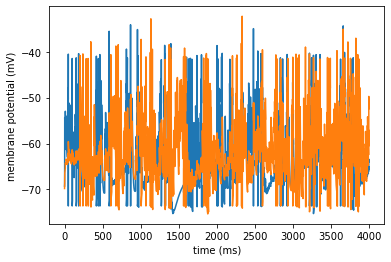

In [90]:
for k in range(2):
    plot(L1_trace.t / ms, L1_trace[k].vm / mV)
print(L1_spikes.count_)

xlabel('time (ms)')
ylabel('membrane potential (mV)')
show()

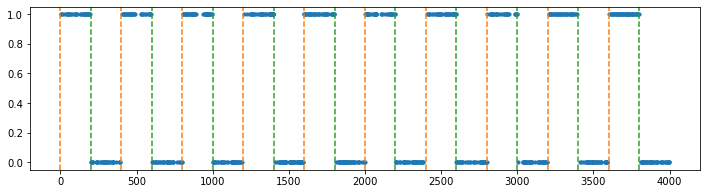

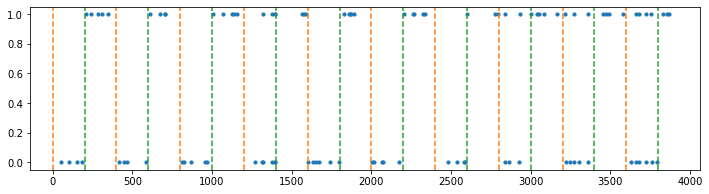

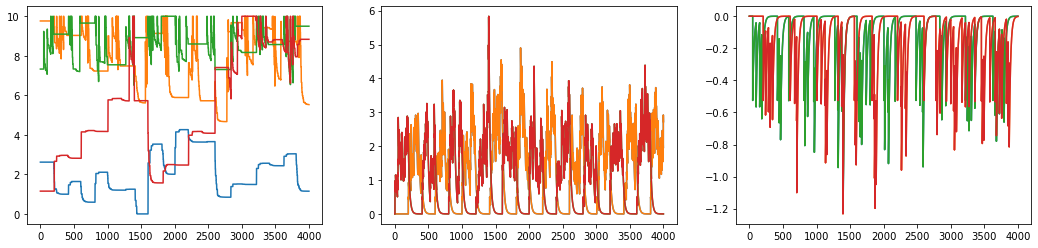

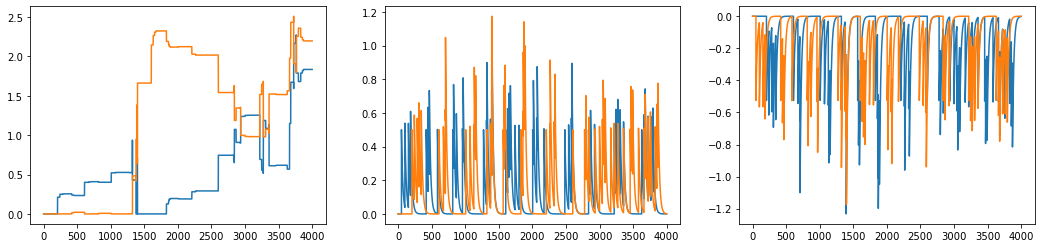

In [91]:
plot_spikes(inPG_spikes)
plot_spikes(L1_spikes)
plot_syn_layer(inL_trace, 4)
plot_syn_layer(ihL_trace, 2)

## Learning

In [25]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(np.zeros(Ns), np.arange(Ns), 'ok', ms=10)
    plot(np.ones(Nt), np.arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
def plot_spikes(mon):
    figure(figsize=(12,3))
    scatter(mon.t/ms, mon.i, s=10)
    for t in range(0, run_time, 2*change_time):
        axvline(t, ls='--', c='C1')
        axvline(t + change_time, ls='--', c='C2')        
    
    show()

def plot_syn_layer(L, n):
    figure(figsize=(18,4))
    subplot(131)
    for k in range(n):
        plot(L.t/ms, L.w_syn[k])
    subplot(132)
    for k in range(n):
        plot(L.t/ms, L.apre[k])
    subplot(133)
    for k in range(n):
        plot(L.t/ms, L.apost[k])
    show()

In [88]:
input_patterns = array([[0., 1.], [1., 0.]])
n_patterns = input_patterns.shape[0]
# input_patterns = input_patterns.reshape((n_patterns, -1))

poisson_params = 200, 1.

# stimulus = TimedArray(np.tile([100., 0.], 5)*Hz, dt=100.*ms)
# P = PoissonGroup(1, rates='stimulus(t)')

poisson_rates = input_patterns * np.random.normal(poisson_params[0], poisson_params[1], size=input_patterns.shape)
poisson_rates

array([[  0.        , 198.92470469],
       [200.04925993,   0.        ]])

In [89]:
start_scope()
seed(1337)

# Parameters
N = 2
C = 281 * pF
gL = 30 * nS
taum = C / gL
EL = -70.6 * mV
VT = -50.4 * mV
DeltaT = 2 * mV
Vcut = VT + 5 * DeltaT
Tr = 5 * ms
I_tonic = 0.3 * .6 * nA

# Pick an electrophysiological behaviour
tauw, a, b, Vr = 144*ms, 4*nS, 0.0805*nA, EL - 3 * mV # Regular spiking (as in the paper)
#tauw,a,b,Vr=20*ms,4*nS,0.5*nA,VT+5*mV # Bursting
# tauw,a,b,Vr=144*ms,2*C/(144*ms), 0*nA, EL - 3 * mV # Fast spiking

# stoch = ' + 0*xi*0.2*nA*ms**.5'
eqs = """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I - w)/C : volt (unless refractory)
dw/dt = (a*(vm - EL) - w)/tauw : amp
I : amp
"""

n_tile = 50
change_time = 200
stimulus = TimedArray(
    np.tile(poisson_rates, (n_tile, 1)) * Hz,
    dt=change_time * ms
)
inPG = PoissonGroup(input_patterns.shape[1], rates='stimulus(t, i)')

L1 = NeuronGroup(
    N, model=eqs, threshold='vm>Vcut',
    reset="vm=Vr; w+=b", 
    refractory='vm>=Vcut',
    method='euler'
)
L1.vm = 'EL + rand()*5*mV'
L1.I = I_tonic

taupre = taupost = 20*ms
w_syn_max = 10.
Apre = 0.05 * w_syn_max
Apost = -Apre*taupre/taupost*1.05
inL = Synapses(
    inPG, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post += w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0., w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='euler'
)
inL.connect()
inL.w_syn = '.2 * w_syn_max * rand() + .4 * w_syn_max * (1 - j) * i + .4 * w_syn_max * (1 - i) * j'
inL.delay = 0 * 2 * ms

ihL = Synapses(
    L1, L1, 
    '''
    w_syn : 1
    dapre/dt = -apre/taupre : 1 (clock-driven)
    dapost/dt = -apost/taupost : 1 (clock-driven)
    ''',    
    on_pre='''
    vm_post -= w_syn * mV
    apre += Apre
    w_syn = clip(w_syn + apost, 0., w_syn_max)
    ''',
    on_post='''
    apost += Apost
    w_syn = clip(w_syn + apre, 0., w_syn_max)
    ''',
    method='euler'
)
ihL.connect(condition='i!=j')
inL.w_syn = 'w_syn_max * rand()'
ihL.delay = 0 * 2 * ms

inPG_spikes = SpikeMonitor(inPG)
L1_trace = StateMonitor(L1, 'vm', record=True)
L1_spikes = SpikeMonitor(L1)
inL_trace = StateMonitor(inL, ['w_syn', 'apre', 'apost'], record=True)
ihL_trace = StateMonitor(ihL, ['w_syn', 'apre', 'apost'], record=True)

run_time = 4000
run(4000 * ms)

# print(inL.w_)
# print(ihL.w_)
# visualise_connectivity(ihL)

<spikemonitor_3.count_: array([48, 55], dtype=int32)>


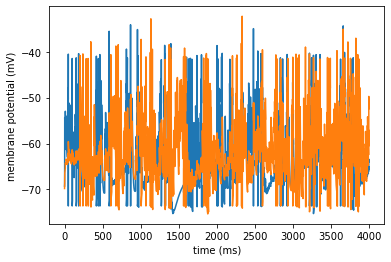

In [90]:
for k in range(2):
    plot(L1_trace.t / ms, L1_trace[k].vm / mV)
print(L1_spikes.count_)

xlabel('time (ms)')
ylabel('membrane potential (mV)')
show()

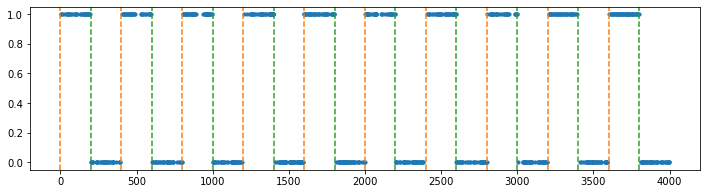

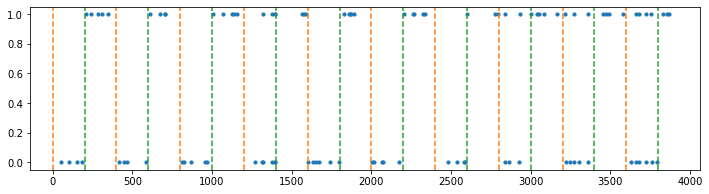

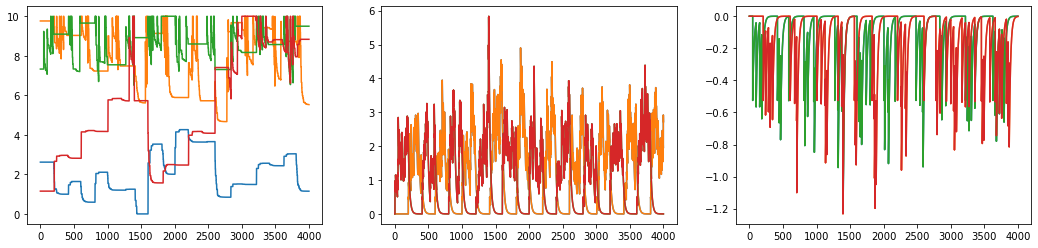

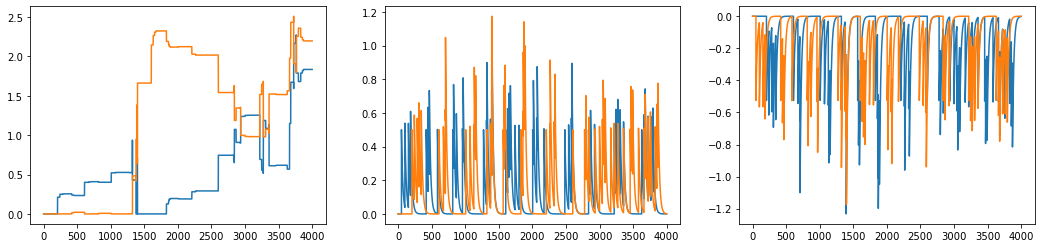

In [91]:
plot_spikes(inPG_spikes)
plot_spikes(L1_spikes)
plot_syn_layer(inL_trace, 4)
plot_syn_layer(ihL_trace, 2)